In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [127]:
df = pd.read_csv('/Users/data/VsCodeProjects/DataScience/data/raw/eurusd_hour.csv')
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93084 entries, 0 to 93083
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    93084 non-null  object 
 1   Time    93084 non-null  object 
 2   BO      93084 non-null  float64
 3   BH      93084 non-null  float64
 4   BL      93084 non-null  float64
 5   BC      93084 non-null  float64
 6   BCh     93084 non-null  float64
 7   AO      93084 non-null  float64
 8   AH      93084 non-null  float64
 9   AL      93084 non-null  float64
 10  AC      93084 non-null  float64
 11  ACh     93084 non-null  float64
dtypes: float64(10), object(2)
memory usage: 8.5+ MB


In [128]:
from datetime import datetime, date, time

#перевод с строки даты в дату общего формата
def str_to_datetime(s: str):
    splited = s.split('-')
    year, month, day = int(splited[0]), int(splited[1]), int(splited[2])
    return datetime.datetime(year=year, month=month, day=day)




Изменение формата времени к объекту datetime

In [129]:
def str_hours_to_datetime(t: str):
    splited = t.split(':')
    hour, minute = int(splited[0]), int(splited[1])
    return datetime.time(hour=hour, minute=minute)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93084 entries, 0 to 93083
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    93084 non-null  object 
 1   Time    93084 non-null  object 
 2   BO      93084 non-null  float64
 3   BH      93084 non-null  float64
 4   BL      93084 non-null  float64
 5   BC      93084 non-null  float64
 6   BCh     93084 non-null  float64
 7   AO      93084 non-null  float64
 8   AH      93084 non-null  float64
 9   AL      93084 non-null  float64
 10  AC      93084 non-null  float64
 11  ACh     93084 non-null  float64
dtypes: float64(10), object(2)
memory usage: 8.5+ MB


In [130]:
df['Date'] = pd.to_datetime(df['Date']).dt.date
df['Time'] = pd.to_datetime(df['Time']).dt.time

/var/folders/9c/vk6dn3k90g9cy2bswv5c6kk00000gn/T/ipykernel_42475/4204116191.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.time


In [131]:
df['Datetime'] = df.apply(lambda row: datetime.combine(date=row['Date'], time=row['Time']), axis=1)

In [132]:
import matplotlib.pyplot as plt

In [51]:
df['Datetime']

0       2005-05-02 00:00:00
1       2005-05-02 01:00:00
2       2005-05-02 02:00:00
3       2005-05-02 03:00:00
4       2005-05-02 04:00:00
                ...        
93079   2020-04-29 18:00:00
93080   2020-04-29 19:00:00
93081   2020-04-29 20:00:00
93082   2020-04-29 21:00:00
93083   2020-04-29 22:00:00
Name: Datetime, Length: 93084, dtype: datetime64[ns]

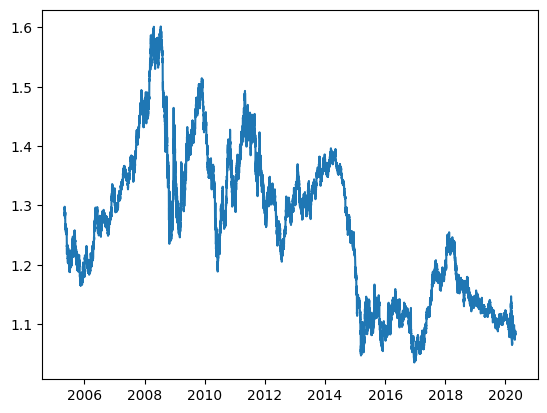

In [52]:
plt.plot(df['Datetime'], df['BC'])


In [133]:
df.index = pd.to_datetime(df['Datetime'])
df = df.drop(columns=['Datetime'])

In [54]:
df.columns

Index(['Date', 'Time', 'BO', 'BH', 'BL', 'BC', 'BCh', 'AO', 'AH', 'AL', 'AC',
       'ACh'],
      dtype='object')

In [134]:
df = df.drop(columns=['Date'])

In [135]:
df = df.drop(columns=['Time'])

In [57]:
df

,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh
Datetime,,,,,,,,,,
2005-05-02 00:00:00,1.28520,1.28520,1.28400,1.28440,-0.00080,1.28540,1.28540,1.28420,1.28460,-0.00080
2005-05-02 01:00:00,1.28440,1.28480,1.28390,1.28420,-0.00020,1.28460,1.28500,1.28410,1.28440,-0.00020
2005-05-02 02:00:00,1.28430,1.28540,1.28410,1.28510,0.00080,1.28450,1.28560,1.28430,1.28530,0.00080
2005-05-02 03:00:00,1.28510,1.28590,1.28500,1.28510,0.00000,1.28530,1.28610,1.28520,1.28530,0.00000
2005-05-02 04:00:00,1.28520,1.28590,1.28490,1.28550,0.00030,1.28540,1.28610,1.28510,1.28570,0.00030
...,...,...,...,...,...,...,...,...,...,...
2020-04-29 18:00:00,1.08620,1.08851,1.08611,1.08713,0.00093,1.08660,1.08865,1.08640,1.08726,0.00066
2020-04-29 19:00:00,1.08711,1.08823,1.08659,1.08748,0.00037,1.08725,1.08837,1.08675,1.08760,0.00035
2020-04-29 20:00:00,1.08747,1.08788,1.08691,1.08708,-0.00039,1.08758,1.08810,1.08706,1.08808,0.00050


In [58]:
df.describe()

,BO,BH,BL,BC,BCh,AO,AH,AL,AC,ACh
count,93084.000000,93084.000000,93084.000000,93084.000000,9.308400e+04,93084.000000,93084.000000,93084.000000,93084.000000,93084.000000
mean,1.265734,1.266755,1.264736,1.265733,-8.928495e-07,1.265900,1.266917,1.264897,1.265899,-0.000001
std,0.126894,0.127060,0.126722,0.126892,1.544143e-03,0.126891,0.127053,0.126715,0.126891,0.001546
min,1.035530,1.036970,1.033950,1.035550,-2.505000e-02,1.035660,1.037100,1.034090,1.035680,-0.024950
25%,1.139878,1.140728,1.139130,1.139880,-6.000000e-04,1.140050,1.140890,1.139300,1.140048,-0.000590
50%,1.274100,1.275315,1.272955,1.274105,1.000000e-05,1.274280,1.275490,1.273150,1.274290,0.000000
75%,1.357615,1.358770,1.356533,1.357630,6.000000e-04,1.357770,1.358920,1.356673,1.357770,0.000600
max,1.601310,1.603840,1.599200,1.601390,3.022000e-02,1.601400,1.603930,1.599290,1.601480,0.030430


In [136]:
df['Price_open'] = df[['BO', 'AO']].mean(axis=1)

In [137]:
df.pop('AO')

Datetime
2005-05-02 00:00:00    1.28540
2005-05-02 01:00:00    1.28460
2005-05-02 02:00:00    1.28450
2005-05-02 03:00:00    1.28530
2005-05-02 04:00:00    1.28540
                        ...   
2020-04-29 18:00:00    1.08660
2020-04-29 19:00:00    1.08725
2020-04-29 20:00:00    1.08758
2020-04-29 21:00:00    1.08808
2020-04-29 22:00:00    1.08756
Name: AO, Length: 93084, dtype: float64

In [138]:
df.pop('BO')

Datetime
2005-05-02 00:00:00    1.28520
2005-05-02 01:00:00    1.28440
2005-05-02 02:00:00    1.28430
2005-05-02 03:00:00    1.28510
2005-05-02 04:00:00    1.28520
                        ...   
2020-04-29 18:00:00    1.08620
2020-04-29 19:00:00    1.08711
2020-04-29 20:00:00    1.08747
2020-04-29 21:00:00    1.08708
2020-04-29 22:00:00    1.08728
Name: BO, Length: 93084, dtype: float64

In [139]:
df['Highest'] = df[['BH', 'AH']].mean(axis=1)
df['Lowest'] = df[['BL', 'AL']].mean(axis=1)

In [140]:
df.pop('BH')
df.pop('AH')
df.pop('AL')
df.pop('BL')

Datetime
2005-05-02 00:00:00    1.28400
2005-05-02 01:00:00    1.28390
2005-05-02 02:00:00    1.28410
2005-05-02 03:00:00    1.28500
2005-05-02 04:00:00    1.28490
                        ...   
2020-04-29 18:00:00    1.08611
2020-04-29 19:00:00    1.08659
2020-04-29 20:00:00    1.08691
2020-04-29 21:00:00    1.08699
2020-04-29 22:00:00    1.08727
Name: BL, Length: 93084, dtype: float64

In [141]:
df

,BC,BCh,AC,ACh,Price_open,Highest,Lowest
Datetime,,,,,,,
2005-05-02 00:00:00,1.28440,-0.00080,1.28460,-0.00080,1.285300,1.285300,1.284100
2005-05-02 01:00:00,1.28420,-0.00020,1.28440,-0.00020,1.284500,1.284900,1.284000
2005-05-02 02:00:00,1.28510,0.00080,1.28530,0.00080,1.284400,1.285500,1.284200
2005-05-02 03:00:00,1.28510,0.00000,1.28530,0.00000,1.285200,1.286000,1.285100
2005-05-02 04:00:00,1.28550,0.00030,1.28570,0.00030,1.285300,1.286000,1.285000
...,...,...,...,...,...,...,...
2020-04-29 18:00:00,1.08713,0.00093,1.08726,0.00066,1.086400,1.088580,1.086255
2020-04-29 19:00:00,1.08748,0.00037,1.08760,0.00035,1.087180,1.088300,1.086670
2020-04-29 20:00:00,1.08708,-0.00039,1.08808,0.00050,1.087525,1.087990,1.086985


In [142]:
df['Price_close'] = df[['BC', 'AC']].mean(axis=1)

In [143]:
df.pop('BC')
df.pop('AC')

Datetime
2005-05-02 00:00:00    1.28460
2005-05-02 01:00:00    1.28440
2005-05-02 02:00:00    1.28530
2005-05-02 03:00:00    1.28530
2005-05-02 04:00:00    1.28570
                        ...   
2020-04-29 18:00:00    1.08726
2020-04-29 19:00:00    1.08760
2020-04-29 20:00:00    1.08808
2020-04-29 21:00:00    1.08766
2020-04-29 22:00:00    1.08760
Name: AC, Length: 93084, dtype: float64

In [144]:
df['change'] = df[['BCh', 'ACh']].mean(axis=1)
df.pop('BCh')
df.pop('ACh')

Datetime
2005-05-02 00:00:00   -0.00080
2005-05-02 01:00:00   -0.00020
2005-05-02 02:00:00    0.00080
2005-05-02 03:00:00    0.00000
2005-05-02 04:00:00    0.00030
                        ...   
2020-04-29 18:00:00    0.00066
2020-04-29 19:00:00    0.00035
2020-04-29 20:00:00    0.00050
2020-04-29 21:00:00   -0.00042
2020-04-29 22:00:00    0.00004
Name: ACh, Length: 93084, dtype: float64

In [145]:
df['Hour'] = df.index.hour
df['hour_sin'] = np.sin(2*np.pi * df.index.hour/24)
df['hour_cos'] = np.cos(2*np.pi * df.index.hour/24)
df.pop('Hour')
df

,Price_open,Highest,Lowest,Price_close,change,hour_sin,hour_cos
Datetime,,,,,,,
2005-05-02 00:00:00,1.285300,1.285300,1.284100,1.284500,-0.000800,0.000000,1.000000e+00
2005-05-02 01:00:00,1.284500,1.284900,1.284000,1.284300,-0.000200,0.258819,9.659258e-01
2005-05-02 02:00:00,1.284400,1.285500,1.284200,1.285200,0.000800,0.500000,8.660254e-01
2005-05-02 03:00:00,1.285200,1.286000,1.285100,1.285200,0.000000,0.707107,7.071068e-01
2005-05-02 04:00:00,1.285300,1.286000,1.285000,1.285600,0.000300,0.866025,5.000000e-01
...,...,...,...,...,...,...,...
2020-04-29 18:00:00,1.086400,1.088580,1.086255,1.087195,0.000795,-1.000000,-1.836970e-16
2020-04-29 19:00:00,1.087180,1.088300,1.086670,1.087540,0.000360,-0.965926,2.588190e-01
2020-04-29 20:00:00,1.087525,1.087990,1.086985,1.087580,0.000055,-0.866025,5.000000e-01


In [146]:
df['log_ret_body'] = np.log(df['Price_close'] / df['Price_open'])
df

,Price_open,Highest,Lowest,Price_close,change,hour_sin,hour_cos,log_ret_body
Datetime,,,,,,,,
2005-05-02 00:00:00,1.285300,1.285300,1.284100,1.284500,-0.000800,0.000000,1.000000e+00,-0.000623
2005-05-02 01:00:00,1.284500,1.284900,1.284000,1.284300,-0.000200,0.258819,9.659258e-01,-0.000156
2005-05-02 02:00:00,1.284400,1.285500,1.284200,1.285200,0.000800,0.500000,8.660254e-01,0.000623
2005-05-02 03:00:00,1.285200,1.286000,1.285100,1.285200,0.000000,0.707107,7.071068e-01,0.000000
2005-05-02 04:00:00,1.285300,1.286000,1.285000,1.285600,0.000300,0.866025,5.000000e-01,0.000233
...,...,...,...,...,...,...,...,...
2020-04-29 18:00:00,1.086400,1.088580,1.086255,1.087195,0.000795,-1.000000,-1.836970e-16,0.000732
2020-04-29 19:00:00,1.087180,1.088300,1.086670,1.087540,0.000360,-0.965926,2.588190e-01,0.000331
2020-04-29 20:00:00,1.087525,1.087990,1.086985,1.087580,0.000055,-0.866025,5.000000e-01,0.000051


In [147]:
df['range'] = (df['Highest'] - df['Lowest']) / df['Price_open']
df

,Price_open,Highest,Lowest,Price_close,change,hour_sin,hour_cos,log_ret_body,range
Datetime,,,,,,,,,
2005-05-02 00:00:00,1.285300,1.285300,1.284100,1.284500,-0.000800,0.000000,1.000000e+00,-0.000623,0.000934
2005-05-02 01:00:00,1.284500,1.284900,1.284000,1.284300,-0.000200,0.258819,9.659258e-01,-0.000156,0.000701
2005-05-02 02:00:00,1.284400,1.285500,1.284200,1.285200,0.000800,0.500000,8.660254e-01,0.000623,0.001012
2005-05-02 03:00:00,1.285200,1.286000,1.285100,1.285200,0.000000,0.707107,7.071068e-01,0.000000,0.000700
2005-05-02 04:00:00,1.285300,1.286000,1.285000,1.285600,0.000300,0.866025,5.000000e-01,0.000233,0.000778
...,...,...,...,...,...,...,...,...,...
2020-04-29 18:00:00,1.086400,1.088580,1.086255,1.087195,0.000795,-1.000000,-1.836970e-16,0.000732,0.002140
2020-04-29 19:00:00,1.087180,1.088300,1.086670,1.087540,0.000360,-0.965926,2.588190e-01,0.000331,0.001499
2020-04-29 20:00:00,1.087525,1.087990,1.086985,1.087580,0.000055,-0.866025,5.000000e-01,0.000051,0.000924


In [148]:
df['upper_wick'] = (df['Highest'] - df[['Price_open', 'Price_close']].max(axis=1)) / df['Price_open']
df

,Price_open,Highest,Lowest,Price_close,change,hour_sin,hour_cos,log_ret_body,range,upper_wick
Datetime,,,,,,,,,,
2005-05-02 00:00:00,1.285300,1.285300,1.284100,1.284500,-0.000800,0.000000,1.000000e+00,-0.000623,0.000934,0.000000
2005-05-02 01:00:00,1.284500,1.284900,1.284000,1.284300,-0.000200,0.258819,9.659258e-01,-0.000156,0.000701,0.000311
2005-05-02 02:00:00,1.284400,1.285500,1.284200,1.285200,0.000800,0.500000,8.660254e-01,0.000623,0.001012,0.000234
2005-05-02 03:00:00,1.285200,1.286000,1.285100,1.285200,0.000000,0.707107,7.071068e-01,0.000000,0.000700,0.000622
2005-05-02 04:00:00,1.285300,1.286000,1.285000,1.285600,0.000300,0.866025,5.000000e-01,0.000233,0.000778,0.000311
...,...,...,...,...,...,...,...,...,...,...
2020-04-29 18:00:00,1.086400,1.088580,1.086255,1.087195,0.000795,-1.000000,-1.836970e-16,0.000732,0.002140,0.001275
2020-04-29 19:00:00,1.087180,1.088300,1.086670,1.087540,0.000360,-0.965926,2.588190e-01,0.000331,0.001499,0.000699
2020-04-29 20:00:00,1.087525,1.087990,1.086985,1.087580,0.000055,-0.866025,5.000000e-01,0.000051,0.000924,0.000377


In [149]:
df['lower_wick'] = (df[['Price_open', 'Price_close']].min(axis=1) - df['Lowest']) / df['Price_open']
df

,Price_open,Highest,Lowest,Price_close,change,hour_sin,hour_cos,log_ret_body,range,upper_wick,lower_wick
Datetime,,,,,,,,,,,
2005-05-02 00:00:00,1.285300,1.285300,1.284100,1.284500,-0.000800,0.000000,1.000000e+00,-0.000623,0.000934,0.000000,0.000311
2005-05-02 01:00:00,1.284500,1.284900,1.284000,1.284300,-0.000200,0.258819,9.659258e-01,-0.000156,0.000701,0.000311,0.000234
2005-05-02 02:00:00,1.284400,1.285500,1.284200,1.285200,0.000800,0.500000,8.660254e-01,0.000623,0.001012,0.000234,0.000156
2005-05-02 03:00:00,1.285200,1.286000,1.285100,1.285200,0.000000,0.707107,7.071068e-01,0.000000,0.000700,0.000622,0.000078
2005-05-02 04:00:00,1.285300,1.286000,1.285000,1.285600,0.000300,0.866025,5.000000e-01,0.000233,0.000778,0.000311,0.000233
...,...,...,...,...,...,...,...,...,...,...,...
2020-04-29 18:00:00,1.086400,1.088580,1.086255,1.087195,0.000795,-1.000000,-1.836970e-16,0.000732,0.002140,0.001275,0.000133
2020-04-29 19:00:00,1.087180,1.088300,1.086670,1.087540,0.000360,-0.965926,2.588190e-01,0.000331,0.001499,0.000699,0.000469
2020-04-29 20:00:00,1.087525,1.087990,1.086985,1.087580,0.000055,-0.866025,5.000000e-01,0.000051,0.000924,0.000377,0.000497


In [150]:
df['close_pos'] = (df['Price_close']-df['Lowest']) / (df['Highest']-df['Lowest'])
df

,Price_open,Highest,Lowest,Price_close,change,hour_sin,hour_cos,log_ret_body,range,upper_wick,lower_wick,close_pos
Datetime,,,,,,,,,,,,
2005-05-02 00:00:00,1.285300,1.285300,1.284100,1.284500,-0.000800,0.000000,1.000000e+00,-0.000623,0.000934,0.000000,0.000311,0.333333
2005-05-02 01:00:00,1.284500,1.284900,1.284000,1.284300,-0.000200,0.258819,9.659258e-01,-0.000156,0.000701,0.000311,0.000234,0.333333
2005-05-02 02:00:00,1.284400,1.285500,1.284200,1.285200,0.000800,0.500000,8.660254e-01,0.000623,0.001012,0.000234,0.000156,0.769231
2005-05-02 03:00:00,1.285200,1.286000,1.285100,1.285200,0.000000,0.707107,7.071068e-01,0.000000,0.000700,0.000622,0.000078,0.111111
2005-05-02 04:00:00,1.285300,1.286000,1.285000,1.285600,0.000300,0.866025,5.000000e-01,0.000233,0.000778,0.000311,0.000233,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-29 18:00:00,1.086400,1.088580,1.086255,1.087195,0.000795,-1.000000,-1.836970e-16,0.000732,0.002140,0.001275,0.000133,0.404301
2020-04-29 19:00:00,1.087180,1.088300,1.086670,1.087540,0.000360,-0.965926,2.588190e-01,0.000331,0.001499,0.000699,0.000469,0.533742
2020-04-29 20:00:00,1.087525,1.087990,1.086985,1.087580,0.000055,-0.866025,5.000000e-01,0.000051,0.000924,0.000377,0.000497,0.592040


In [151]:
#FOR UTC-3 зимнее время
asia_open, asia_close = 2, 10
frankfurt_open, frankfurt_close = 10, 11
london_open, london_close = 11, 19
ny_open, ny_close = 16, 0

In [152]:
df['is_asia'] = ((df.index.hour >= asia_open) & (df.index.hour <= asia_close)).astype(int)
df['is_frankfurt'] = ((df.index.hour >= frankfurt_open) & (df.index.hour <= frankfurt_close)).astype(int)
df['is_london'] = ((df.index.hour >= london_open) & (df.index.hour <= london_close)).astype(int)
df['is_ny'] = ((df.index.hour >= ny_open) & (df.index.hour <= ny_close)).astype(int)

In [153]:
f_change = df['is_frankfurt'].diff().abs() > 0
l_change = df['is_london'].diff().abs() > 0
n_change = df['is_ny'].diff().abs() > 0


In [154]:
df['if_change'] = (f_change | l_change | n_change).astype(int)
df

,Price_open,Highest,Lowest,Price_close,change,hour_sin,hour_cos,log_ret_body,range,upper_wick,lower_wick,close_pos,is_asia,is_frankfurt,is_london,is_ny,if_change
Datetime,,,,,,,,,,,,,,,,,
2005-05-02 00:00:00,1.285300,1.285300,1.284100,1.284500,-0.000800,0.000000,1.000000e+00,-0.000623,0.000934,0.000000,0.000311,0.333333,0,0,0,0,0
2005-05-02 01:00:00,1.284500,1.284900,1.284000,1.284300,-0.000200,0.258819,9.659258e-01,-0.000156,0.000701,0.000311,0.000234,0.333333,0,0,0,0,0
2005-05-02 02:00:00,1.284400,1.285500,1.284200,1.285200,0.000800,0.500000,8.660254e-01,0.000623,0.001012,0.000234,0.000156,0.769231,1,0,0,0,0
2005-05-02 03:00:00,1.285200,1.286000,1.285100,1.285200,0.000000,0.707107,7.071068e-01,0.000000,0.000700,0.000622,0.000078,0.111111,1,0,0,0,0
2005-05-02 04:00:00,1.285300,1.286000,1.285000,1.285600,0.000300,0.866025,5.000000e-01,0.000233,0.000778,0.000311,0.000233,0.600000,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-29 18:00:00,1.086400,1.088580,1.086255,1.087195,0.000795,-1.000000,-1.836970e-16,0.000732,0.002140,0.001275,0.000133,0.404301,0,0,1,0,0
2020-04-29 19:00:00,1.087180,1.088300,1.086670,1.087540,0.000360,-0.965926,2.588190e-01,0.000331,0.001499,0.000699,0.000469,0.533742,0,0,1,0,0
2020-04-29 20:00:00,1.087525,1.087990,1.086985,1.087580,0.000055,-0.866025,5.000000e-01,0.000051,0.000924,0.000377,0.000497,0.592040,0,0,0,0,1


In [104]:
df.columns

Index(['Price_open', 'Highest', 'Lowest', 'Price_close', 'change', 'hour_sin',
       'hour_cos', 'log_ret_body', 'range', 'upper_wick', 'lower_wick',
       'close_pos', 'is_asia', 'is_frankfurt', 'is_london', 'is_ny',
       'session_change', 'if_change'],
      dtype='object')

In [155]:
momentum = [3, 6, 12]
volatility = [3, 6, 12]
pressure = [3, 6]


In [156]:
for i in momentum:
    df[f'mom_{i}'] = df['log_ret_body'].rolling(i).sum()

for i in volatility:
    df[f'vol_{i}'] = df['log_ret_body'].rolling(i).std()

for i in pressure:
    df[f'pressure_{i}'] = df['close_pos'].rolling(i).mean()

In [157]:
df['target_delta'] = np.log(df['Price_close'].shift(-1) / df['Price_close'])
df['target_dir'] = (df['target_delta'] > 0).astype(int)

In [109]:
df

,Price_open,Highest,Lowest,Price_close,change,hour_sin,hour_cos,log_ret_body,range,upper_wick,...,mom_3,mom_6,mom_12,vol_3,vol_6,vol_12,pressure_3,pressure_6,target_delta,target_dir
Datetime,,,,,,,,,,,,,,,,,,,,,
2005-05-02 00:00:00,1.285300,1.285300,1.284100,1.284500,-0.000800,0.000000,1.000000e+00,-0.000623,0.000934,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000156,0
2005-05-02 01:00:00,1.284500,1.284900,1.284000,1.284300,-0.000200,0.258819,9.659258e-01,-0.000156,0.000701,0.000311,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000701,1
2005-05-02 02:00:00,1.284400,1.285500,1.284200,1.285200,0.000800,0.500000,8.660254e-01,0.000623,0.001012,0.000234,...,-0.000156,NaN,NaN,0.000629,NaN,NaN,0.478632,NaN,0.000000,0
2005-05-02 03:00:00,1.285200,1.286000,1.285100,1.285200,0.000000,0.707107,7.071068e-01,0.000000,0.000700,0.000622,...,0.000467,NaN,NaN,0.000412,NaN,NaN,0.404558,NaN,0.000311,1
2005-05-02 04:00:00,1.285300,1.286000,1.285000,1.285600,0.000300,0.866025,5.000000e-01,0.000233,0.000778,0.000311,...,0.000856,NaN,NaN,0.000315,NaN,NaN,0.493447,NaN,-0.000078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-29 18:00:00,1.086400,1.088580,1.086255,1.087195,0.000795,-1.000000,-1.836970e-16,0.000732,0.002140,0.001275,...,0.001818,0.001353,0.001892,0.001001,0.000948,0.001008,0.427633,0.485811,0.000317,1
2020-04-29 19:00:00,1.087180,1.088300,1.086670,1.087540,0.000360,-0.965926,2.588190e-01,0.000331,0.001499,0.000699,...,0.002601,0.001063,0.000487,0.000615,0.000931,0.000881,0.591658,0.459912,0.000037,1
2020-04-29 20:00:00,1.087525,1.087990,1.086985,1.087580,0.000055,-0.866025,5.000000e-01,0.000051,0.000924,0.000377,...,0.001113,0.002255,0.000901,0.000342,0.000689,0.000872,0.510028,0.496041,-0.000166,0


In [158]:
ex = ['Price_open', 'Price_close', 'Highest', 'Lowest', 'change', 'target_delta', 'target_dir']

features = [i for i in df.columns if i not in ex]

In [159]:
df = df.dropna()


In [161]:
df = df.dropna(subset=['target_delta'])


In [163]:
y_delta = df['target_delta'].values
print(np.isnan(y_delta).sum())  # долж

0


In [164]:
X_all = df[features].values
y_delta = df['target_delta'].values
y_dir = df['target_dir'].values

In [165]:
X, y_delta_l, y_dir_l = [], [], []
window_len = 72

for i in range(len(df) - window_len):
    X.append(X_all[i:i+window_len])
    y_delta_l.append(y_delta[i + window_len])
    y_dir_l.append(y_dir[i+window_len])

X = np.array(X)
y_delta = np.array(y_delta_l).reshape(-1, 1)
y_dir = np.array(y_dir_l).reshape(-1, 1)

train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train_delta, y_train_dir = X[:train_size], y_delta[:train_size], y_dir[:train_size]
X_val, y_val_delta, y_val_dir = X[train_size:train_size+val_size], y_delta[train_size:train_size+val_size], y_dir[train_size:train_size+val_size]
X_test, y_test_delta, y_test_dir = X[train_size+val_size:], y_delta[train_size+val_size:], y_dir[train_size+val_size:]

In [166]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_2d = X_train.reshape(-1, X_train.shape[-1])
scaler.fit(X_train_2d)

def scale_windows(X):
    X_2d = X.reshape(-1, X.shape[-1])
    X_scaled = scaler.transform(X_2d)
    return X_scaled.reshape(X.shape)

X_train = scale_windows(X_train)
X_val   = scale_windows(X_val)
X_test  = scale_windows(X_test)



In [167]:
X_all = df[features].values
y_all = df['Price_close'].values

In [119]:
df = df.dropna(subset=['target_delta', 'target_dir'])
df = df.dropna()
print(df.isna().sum())


Price_open        0
Highest           0
Lowest            0
Price_close       0
change            0
hour_sin          0
hour_cos          0
log_ret_body      0
range             0
upper_wick        0
lower_wick        0
close_pos         0
is_asia           0
is_frankfurt      0
is_london         0
is_ny             0
session_change    0
if_change         0
mom_3             0
mom_6             0
mom_12            0
vol_3             0
vol_6             0
vol_12            0
pressure_3        0
pressure_6        0
target_delta      0
target_dir        0
dtype: int64


In [125]:
df.fillna(0, inplace=True)  # проще всего для начала
assert (df['Price_close'] > 0).all(), "Есть нули в Price_close!"


In [168]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

seq_len = X_train.shape[1]
n_features = X_train.shape[2]
hidden_size = 128
dropout_rate = 0.2

inputs = Input(shape=(seq_len, n_features))

x = LSTM(hidden_size, return_sequences=False)(inputs)
x = Dropout(dropout_rate)(x)

shared = Dense(hidden_size, activation='relu')(x)

delta_output = Dense(1, name='delta')(shared)
direction_output = Dense(1, activation='sigmoid', name='direction')(shared)

model = Model(inputs=inputs, outputs=[delta_output, direction_output])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'delta': 'mse',
        'direction': 'binary_crossentropy'
    },
    loss_weights={
        'delta': 0.7,     
        'direction': 0.3
    },
    metrics={
        'delta': ['mse'],
        'direction': ['accuracy']
    }
)

model.summary()

history = model.fit(
    X_train,
    {'delta': y_train_delta, 'direction': y_train_dir},
    validation_data=(X_val, {'delta': y_val_delta, 'direction': y_val_dir}),
    epochs=50,
    batch_size=64,
    shuffle=False 
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 72, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 128)       │     76,288 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     16,512 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ delta (Dense)       │ (None, 1)         │        129 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ direction (Dense)   │ (None, 1)         │        129 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,058 (363.51 KB)

 Trainable params: 93,058 (363.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - delta_loss: 5.0106e-04 - delta_mse: 5.0110e-04 - direction_accuracy: 0.5154 - direction_loss: 0.6929 - loss: 0.2082 - val_delta_loss: 3.2530e-05 - val_delta_mse: 3.2503e-05 - val_direction_accuracy: 0.5105 - val_direction_loss: 0.6926 - val_loss: 0.2078
Epoch 2/50
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - delta_loss: 5.3479e-05 - delta_mse: 5.3482e-05 - direction_accuracy: 0.5200 - direction_loss: 0.6923 - loss: 0.2077 - val_delta_loss: 9.4911e-06 - val_delta_mse: 9.4892e-06 - val_direction_accuracy: 0.5133 - val_direction_loss: 0.6924 - val_loss: 0.2077
Epoch 3/50
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - delta_loss: 1.5729e-05 - delta_mse: 1.5730e-05 - direction_accuracy: 0.5212 - direction_loss: 0.6919 - loss: 0.2076 - val_delta_loss: 2.1797e-06 - val_delta_mse: 2.1788e-06 - val_direction_accuracy: 0.5125 - val_direction_loss: 0.6923 - val_loss: 0.2077
Epoch 4/50
1017/1017 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - delta_

In [169]:
pred_delta, pred_dir = model.predict(X_test)
pred_dir_label = (pred_dir > 0.5).astype(int)


from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_delta, pred_delta)
mae = mean_absolute_error(y_test_delta, pred_delta)

print(f"Delta prediction: MSE={mse:.6f}, MAE={mae:.6f}")




436/436 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Delta prediction: MSE=0.000002, MAE=0.000873


In [178]:
y_train_dir

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]], shape=(65083, 1))

In [179]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=200)
clf.fit(X_train_2d, y_train_dir.reshape(len(y_train_dir)))
pred = clf.predict(X_test_2d)

print("Acc:", accuracy_score(y_test_dir, pred))


ValueError: Found input variables with inconsistent numbers of samples: [4685976, 65083]

In [170]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test_dir, pred_dir_label)
f1 = f1_score(y_test_dir, pred_dir_label)
cm = confusion_matrix(y_test_dir, pred_dir_label)

print(f"Direction prediction: Accuracy={accuracy:.3f}, F1={f1:.3f}")
print("Confusion matrix:\n", cm)


Direction prediction: Accuracy=0.500, F1=0.480
Confusion matrix:
 [[3753 3247]
 [3724 3223]]


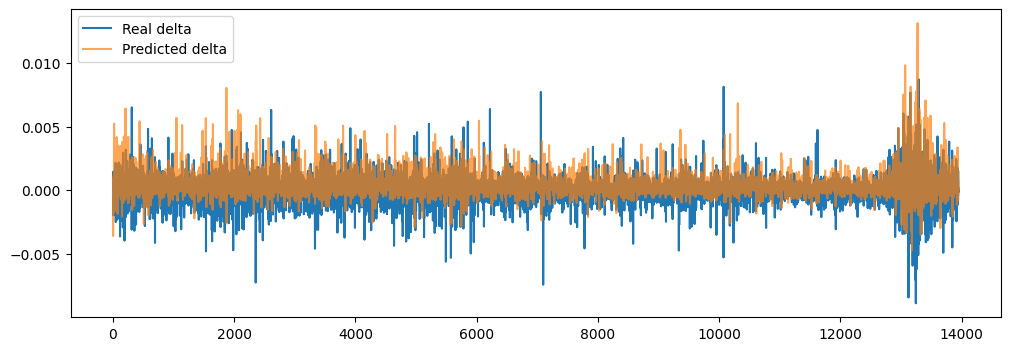

In [171]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_test_delta, label='Real delta')
plt.plot(pred_delta, label='Predicted delta', alpha=0.7)
plt.legend()
plt.show()


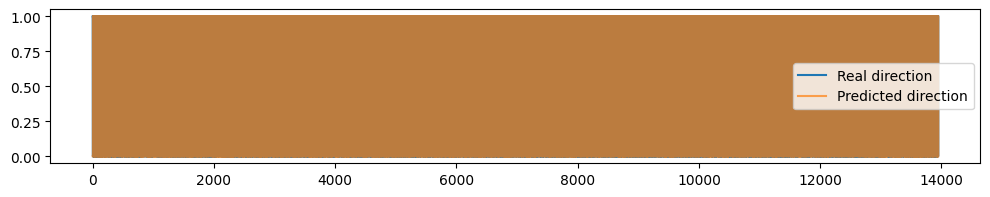

In [172]:
plt.figure(figsize=(12,2))
plt.plot(y_test_dir, label='Real direction')
plt.plot(pred_dir_label, label='Predicted direction', alpha=0.7)
plt.legend()
plt.show()


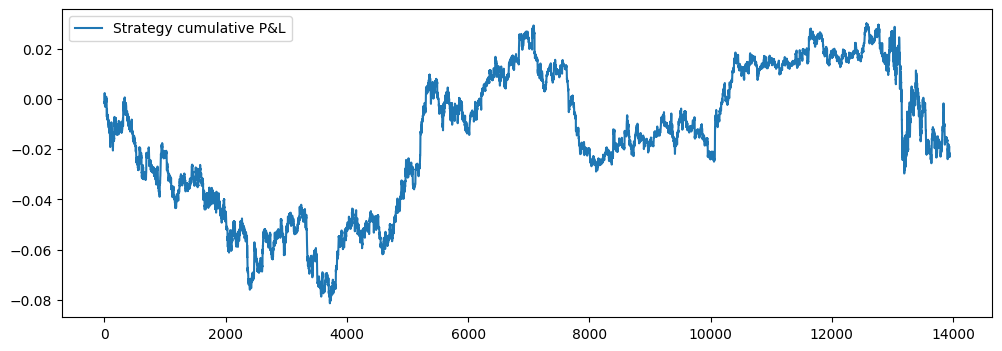

In [173]:
# Движение на основе предсказанного направления
profit = (pred_dir_label.flatten()*2 - 1) * (y_test_delta.flatten())
cumulative_profit = profit.cumsum()

plt.figure(figsize=(12,4))
plt.plot(cumulative_profit, label='Strategy cumulative P&L')
plt.legend()
plt.show()


In [27]:
print(X_all.shape)
print(y_all.shape)
print(len(df) - 72)


(93084, 7)
(93084,)
93012


In [28]:
window_len = 72

X = []
y = []

for i in range(len(df)-window_len):
    X.append(X_all[i:i+window_len])
    y.append(y_all[i+window_len])

X = np.array(X)
y = np.array(y).reshape(-1, 1)
X.shape
y.shape

(93012, 1)

In [29]:
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [30]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
num_features = ['Price_open', 'Highest', 'Lowest', 'Price_close', 'change']

X_train_reshaped = X_train[:, :, :len(num_features)].reshape(-1, len(num_features))
X_val_reshaped = X_val[:, :, :len(num_features)].reshape(-1, len(num_features))
X_test_reshaped = X_test[:, :, :len(num_features)].reshape(-1, len(num_features))

scaler.fit(X_train_reshaped)


X_train[:, :, :len(num_features)] = scaler.transform(X_train_reshaped).reshape(X_train[:, :, :len(num_features)].shape)
X_val[:, :, :len(num_features)] = scaler.transform(X_val_reshaped).reshape(X_val[:, :, :len(num_features)].shape)
X_test[:, :, :len(num_features)] = scaler.transform(X_test_reshaped).reshape(X_test[:, :, :len(num_features)].shape)

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
y_val = y_scaler.transform(y_val.reshape(-1,1))
y_test = y_scaler.transform(y_test.reshape(-1,1))


In [31]:
from tensorflow.keras.layers import Conv1D

model3 = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal',
           input_shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'),
    
    Dropout(0.2),

    LSTM(128, return_sequences=False),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

model3.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
history = model3.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=100,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/100


/Users/data/VsCodeProjects/DataScience/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4070/4070 ━━━━━━━━━━━━━━━━━━━━ 64s 15ms/step - loss: 0.0018 - mae: 0.0264 - val_loss: 1.5353e-04 - val_mae: 0.0093 - learning_rate: 1.0000e-04
Epoch 2/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - loss: 3.2730e-04 - mae: 0.0135 - val_loss: 7.3623e-05 - val_mae: 0.0064 - learning_rate: 1.0000e-04
Epoch 3/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - loss: 1.8287e-04 - mae: 0.0101 - val_loss: 6.2461e-05 - val_mae: 0.0061 - learning_rate: 1.0000e-04
Epoch 4/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - loss: 1.2322e-04 - mae: 0.0082 - val_loss: 5.4608e-05 - val_mae: 0.0054 - learning_rate: 5.0000e-05
Epoch 5/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - loss: 1.1164e-04 - mae: 0.0078 - val_loss: 4.9734e-05 - val_mae: 0.0052 - learning_rate: 5.0000e-05
Epoch 6/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 66s 16ms/step - loss: 1.0303e-04 - mae: 0.0076 - val_loss: 6.9589e-05 - val_mae: 0.0066 - learning_rate: 5.0000e-05
Epoch 7/100
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - los

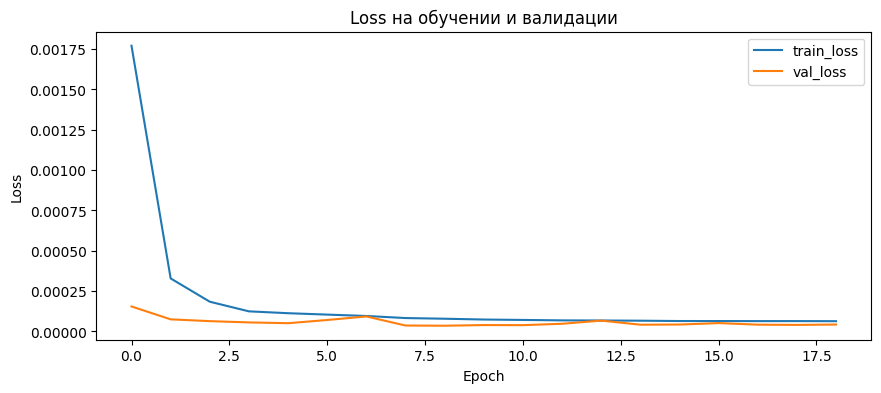

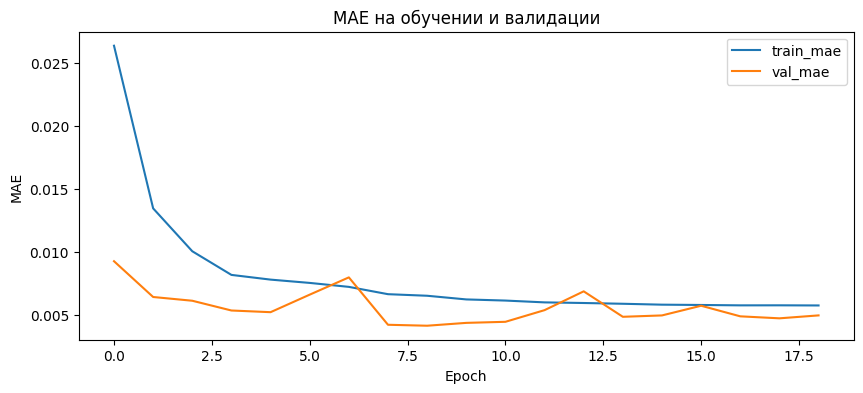

In [32]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss на обучении и валидации')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('MAE на обучении и валидации')
plt.legend()
plt.show()


In [41]:
y_pred_scaled = model3.predict(X_test)


437/437 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


In [42]:
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_test)

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_true, y_pred)


rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.0018
RMSE: 0.0025


#ДЛЯ ПЕРВОЙ МОДЕЛИ:
    MAE: 0.0145
    RMSE: 0.0154

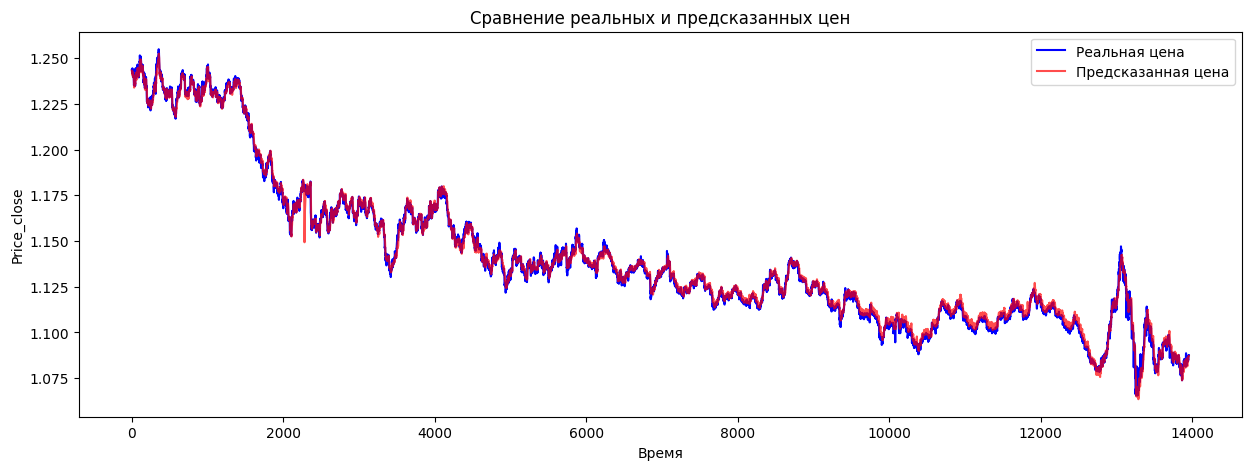

In [45]:
import matplotlib.pyplot as plt

# y_true и y_pred — реальные значения (обратно преобразованные через scaler)
plt.figure(figsize=(15,5))
plt.plot(y_true, label='Реальная цена', color='blue')
plt.plot(y_pred, label='Предсказанная цена', color='red', alpha=0.7)
plt.title('Сравнение реальных и предсказанных цен')
plt.xlabel('Время')
plt.ylabel('Price_close')
plt.legend()
plt.show()


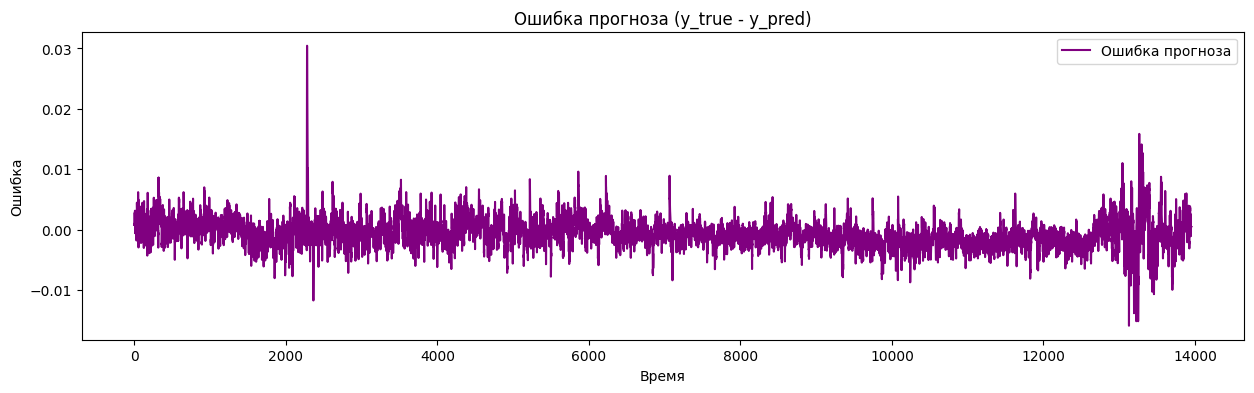

In [38]:
plt.figure(figsize=(15,4))
plt.plot(y_true - y_pred, label='Ошибка прогноза', color='purple')
plt.title('Ошибка прогноза (y_true - y_pred)')
plt.xlabel('Время')
plt.ylabel('Ошибка')
plt.legend()
plt.show()


In [39]:
import numpy as np

# y_true и y_pred — это массивы с ценами
direction_true = np.sign(y_true[1:] - y_true[:-1])   # 1 если вверх, -1 если вниз, 0 если без изменений
direction_pred = np.sign(y_pred[1:] - y_true[:-1])   # сравниваем предсказание с предыдущей реальной ценой
direction_true[direction_true == 0] = 1
direction_pred[direction_pred == 0] = 1
accuracy = np.mean(direction_true == direction_pred)
print("Accuracy движения цены:", accuracy)

Accuracy движения цены: 0.5121846330275229


In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def price_direction_accuracy(y_true, y_pred):
    """
    y_true: массив реальных цен
    y_pred: массив предсказанных цен
    """
    # Вычисляем направление: 1 = вверх, -1 = вниз, 0 = без изменений
    direction_true = np.sign(y_true[1:] - y_true[:-1])
    direction_pred = np.sign(y_pred[1:] - y_true[:-1])

    # Обработка нулевого движения (можно считать вверх)
    direction_true[direction_true == 0] = 1
    direction_pred[direction_pred == 0] = 1

    # Accuracy
    accuracy = np.mean(direction_true == direction_pred)

    # Confusion matrix
    cm = confusion_matrix(direction_true, direction_pred, labels=[1, -1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Up", "Down"])
    
    return accuracy, disp


accuracy, disp = price_direction_accuracy(y_true, y_pred)
print("Accuracy движения цены:", accuracy)
disp.plot()


NameError: name 'y_true' is not defined